# pvlib-Python Forecasting (Denver, CO)
### Install Standard Release 

In [1]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (20.1)


In [2]:
# Package from the Python Package Index
!pip install pvlib

# Module netCDF4 was not found 
!pip install netCDF4

# Module siphon was not found
!pip install siphon

# Downgrade to the prior release 
!pip install cftime==1.1.2
# 4/20/2020: version 1.1.2 released. Code optimization, fix logic so only_use_cftime_datimes=False works as expected (issues #158 and #165).

# Try to save Excel
!pip install openpyxl

In [3]:
def num2pydate(times,units,calendar='standard'):
    """num2pydate(times,units,calendar='standard')
    Always returns python datetime.datetime
    objects and raise an error if this is not possible.
    Same as
    num2date(times,units,calendar,only_use_cftime_datetimes=False,only_use_python_datetimes=True)
    """
    return num2date(times,units,calendar,only_use_cftime_datetimes=False,only_use_python_datetimes=True)

In [4]:
# Make basic imports and then set the location and time range data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import seaborn as sns; sns.set_color_codes()
import datetime

# Import pvlib forecast models
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
from pvlib import solarposition
from pvlib.location import Location
from matplotlib.pyplot import figure
%matplotlib inline

# Specify Location (Albuiquerque, NM)
latitude, longitude, tz = 39.7, -105.2, 'US/Mountain'

# Specify time range
start = pd.Timestamp(datetime.date.today(), tz=tz)
end = start + pd.Timedelta(days=4)
irrad_vars = ['ghi','dni','dhi']

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/pvlib/forecast.py:19: UserWarning: The forecast module algorithms and features are highly experimental. The API may change, the functionality may be consolidated into an io module, or the module may be separated into its own package.
  'The forecast module algorithms and features are highly experimental. '


In [5]:
pytz.all_timezones

['Africa/Abidjan',
 'Africa/Accra',
 'Africa/Addis_Ababa',
 'Africa/Algiers',
 'Africa/Asmara',
 'Africa/Asmera',
 'Africa/Bamako',
 'Africa/Bangui',
 'Africa/Banjul',
 'Africa/Bissau',
 'Africa/Blantyre',
 'Africa/Brazzaville',
 'Africa/Bujumbura',
 'Africa/Cairo',
 'Africa/Casablanca',
 'Africa/Ceuta',
 'Africa/Conakry',
 'Africa/Dakar',
 'Africa/Dar_es_Salaam',
 'Africa/Djibouti',
 'Africa/Douala',
 'Africa/El_Aaiun',
 'Africa/Freetown',
 'Africa/Gaborone',
 'Africa/Harare',
 'Africa/Johannesburg',
 'Africa/Juba',
 'Africa/Kampala',
 'Africa/Khartoum',
 'Africa/Kigali',
 'Africa/Kinshasa',
 'Africa/Lagos',
 'Africa/Libreville',
 'Africa/Lome',
 'Africa/Luanda',
 'Africa/Lubumbashi',
 'Africa/Lusaka',
 'Africa/Malabo',
 'Africa/Maputo',
 'Africa/Maseru',
 'Africa/Mbabane',
 'Africa/Mogadishu',
 'Africa/Monrovia',
 'Africa/Nairobi',
 'Africa/Ndjamena',
 'Africa/Niamey',
 'Africa/Nouakchott',
 'Africa/Ouagadougou',
 'Africa/Porto-Novo',
 'Africa/Sao_Tome',
 'Africa/Timbuktu',
 'Africa/

In [6]:
pytz.country_timezones('US')

['America/New_York',
 'America/Detroit',
 'America/Kentucky/Louisville',
 'America/Kentucky/Monticello',
 'America/Indiana/Indianapolis',
 'America/Indiana/Vincennes',
 'America/Indiana/Winamac',
 'America/Indiana/Marengo',
 'America/Indiana/Petersburg',
 'America/Indiana/Vevay',
 'America/Chicago',
 'America/Indiana/Tell_City',
 'America/Indiana/Knox',
 'America/Menominee',
 'America/North_Dakota/Center',
 'America/North_Dakota/New_Salem',
 'America/North_Dakota/Beulah',
 'America/Denver',
 'America/Boise',
 'America/Phoenix',
 'America/Los_Angeles',
 'America/Anchorage',
 'America/Juneau',
 'America/Sitka',
 'America/Metlakatla',
 'America/Yakutat',
 'America/Nome',
 'America/Adak',
 'Pacific/Honolulu']

### Instantiate a GFS model object and get the forecast data from Unidata

In [7]:
# GFS model, defaults to 0.5 degree resolution
# 0.25 deg available 
model = GFS() 

# Retrive data.returns panda.DataFrame object
raw_data = model.get_data(latitude, longitude, start, end)
print(raw_data.head())

                           Wind_speed_gust_surface  Temperature_surface  \
2020-05-04 06:00:00-06:00                 5.312844           284.648438   
2020-05-04 09:00:00-06:00                 1.033294           284.722168   
2020-05-04 12:00:00-06:00                 5.300743           280.338928   
2020-05-04 15:00:00-06:00                 1.616123           290.516754   
2020-05-04 18:00:00-06:00                 3.689108           298.200012   

                           Total_cloud_cover_convective_cloud  \
2020-05-04 06:00:00-06:00                                 0.0   
2020-05-04 09:00:00-06:00                                 0.0   
2020-05-04 12:00:00-06:00                                 0.0   
2020-05-04 15:00:00-06:00                                 0.0   
2020-05-04 18:00:00-06:00                                 0.0   

                           Total_cloud_cover_entire_atmosphere_Mixed_intervals_Average  \
2020-05-04 06:00:00-06:00                                           

### Process Data with pvlib

In [8]:
# Process this data before using it with pvlib
data = raw_data

# Rename the columns according the key/value pairs in model.variables.
data = model.rename(data)

# Convert temperature
data['temp_air'] = model.kelvin_to_celsius(data['temp_air'])

# Convert wind components to wind speed
data['wind_speed'] = model.uv_to_speed(data)

# Calculate irradiance estimates from cloud cover.
irrad_data = model.cloud_cover_to_irradiance(data['total_clouds'])
data = data.join(irrad_data, how='outer')

# Keep only the final data
data = data[model.output_variables]

print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-04 06:00:00-06:00  11.498444    2.334683    0.011847    0.000000   
2020-05-04 09:00:00-06:00  11.572174    0.881790  172.677552    3.765198   
2020-05-04 12:00:00-06:00   7.188934    2.987157  594.509053  162.704397   
2020-05-04 15:00:00-06:00  17.366760    1.680459  440.498071   76.608128   
2020-05-04 18:00:00-06:00  25.050018    4.600222  211.432363  187.869974   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-04 06:00:00-06:00    0.011847          70.0        33.0        16.0   
2020-05-04 09:00:00-06:00  170.589422         100.0       100.0        28.0   
2020-05-04 12:00:00-06:00  449.007973          50.0        50.0        14.0   
2020-05-04 15:00:00-06:00  378.085687          68.0        68.0         0.0   
2020-05-04 18:00:00-06:00  143.260369          38.0        38.0         0.0   

                           high_clouds  
2020-05-04 06:00:00-06:00  

### GFS'S Class

In [9]:
# process_data method combines these steps in a single function
data = model.process_data(raw_data)
print(data.head())

# Implement their own process_data methods on inherited classes or implement similar stand-alone functions
# Also implement a get_processed_data() method that combines the get_data() and process_data() calls
data = model.get_processed_data(latitude, longitude, start, end)
print(data.head())

                            temp_air  wind_speed         ghi         dni  \
2020-05-04 06:00:00-06:00  11.498444    2.334683    0.011847    0.000000   
2020-05-04 09:00:00-06:00  11.572174    0.881790  172.677552    3.765198   
2020-05-04 12:00:00-06:00   7.188934    2.987157  594.509053  162.704397   
2020-05-04 15:00:00-06:00  17.366760    1.680459  440.498071   76.608128   
2020-05-04 18:00:00-06:00  25.050018    4.600222  211.432363  187.869974   

                                  dhi  total_clouds  low_clouds  mid_clouds  \
2020-05-04 06:00:00-06:00    0.011847          70.0        33.0        16.0   
2020-05-04 09:00:00-06:00  170.589422         100.0       100.0        28.0   
2020-05-04 12:00:00-06:00  449.007973          50.0        50.0        14.0   
2020-05-04 15:00:00-06:00  378.085687          68.0        68.0         0.0   
2020-05-04 18:00:00-06:00  143.260369          38.0        38.0         0.0   

                           high_clouds  
2020-05-04 06:00:00-06:00  

## Cloud Cover & Radiation

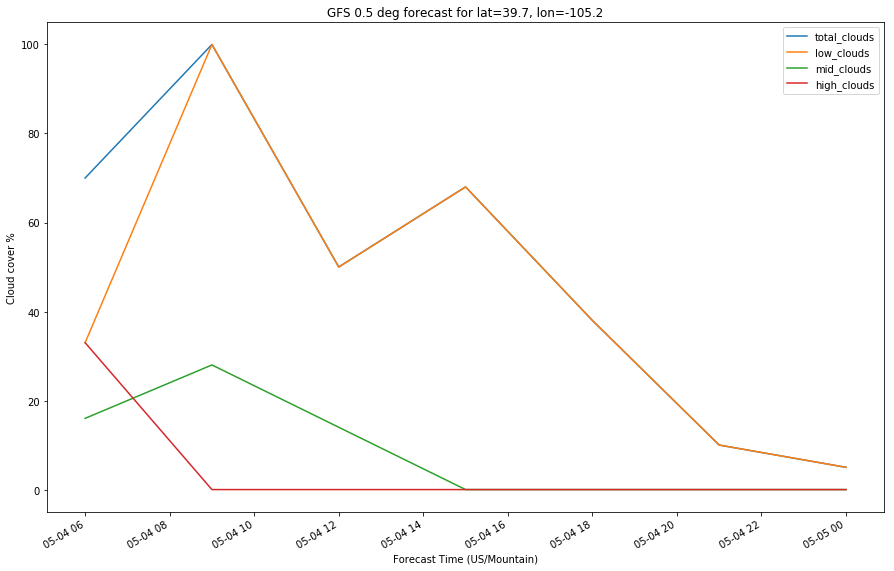

In [10]:
# Plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds','mid_clouds', 'high_clouds']
data[cloud_vars].plot(figsize=(15,10));
plt.ylabel('Cloud cover %');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

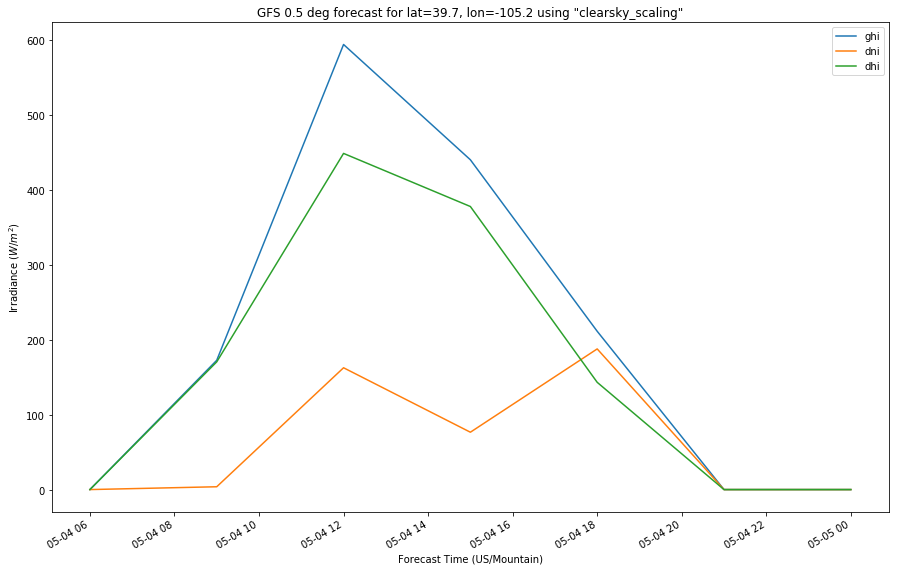

In [11]:
# Plot irradiance data
data = model.rename(raw_data)
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='clearsky_scaling')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitude, longitude));
plt.legend();

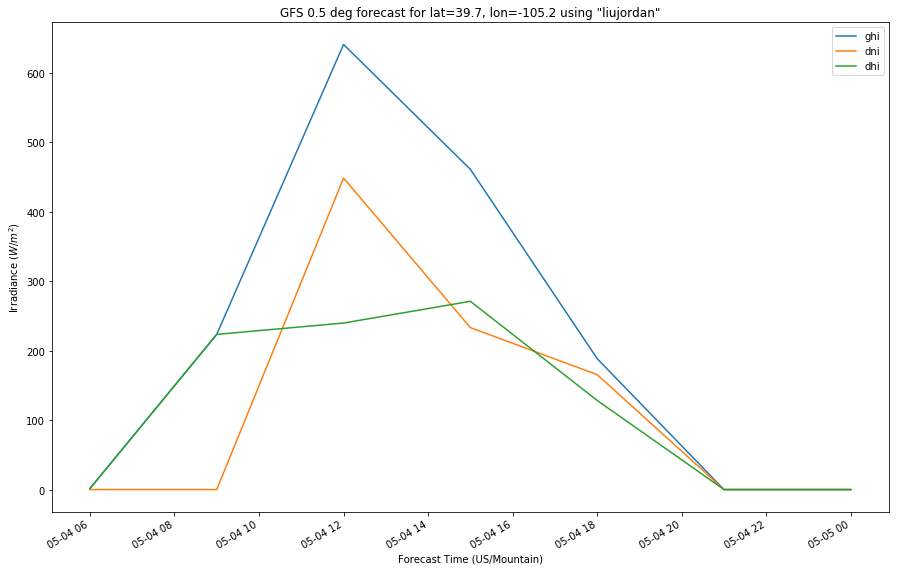

In [12]:
# Plot irradiance data
# Irradiance forecast one hour resolution as the weather data
irrads = model.cloud_cover_to_irradiance(data['total_clouds'], how='liujordan')
irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "liujordan"'.format(latitude, longitude));
plt.legend();

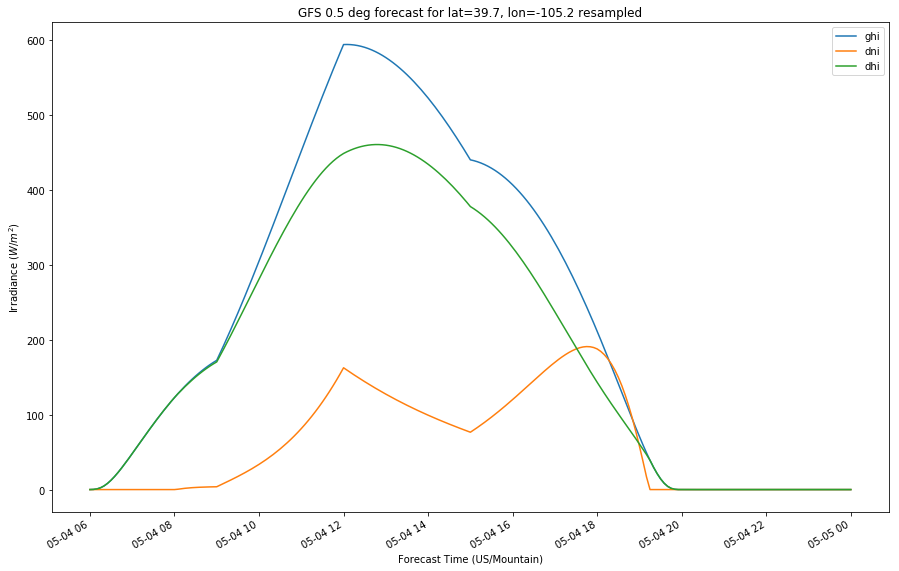

In [13]:
# Five min data resample
resampled_data = data.resample('5min').interpolate()
resampled_irrads = model.cloud_cover_to_irradiance(resampled_data['total_clouds'], how='clearsky_scaling')
resampled_irrads.plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('GFS 0.5 deg forecast for lat={}, lon={} resampled'.format(latitude,longitude));
plt.legend();

In [14]:
resampled_irrads

,ghi,dni,dhi
2020-05-04 06:00:00-06:00,0.011847,0.000000,0.011847
2020-05-04 06:05:00-06:00,0.200283,0.000000,0.200283
2020-05-04 06:10:00-06:00,0.882821,0.000000,0.882821
2020-05-04 06:15:00-06:00,2.382267,0.000000,2.382267
2020-05-04 06:20:00-06:00,4.851537,0.000000,4.851537
2020-05-04 06:25:00-06:00,8.271324,0.000000,8.271324
2020-05-04 06:30:00-06:00,12.525390,0.000000,12.525390
2020-05-04 06:35:00-06:00,17.465044,0.000000,17.465044
2020-05-04 06:40:00-06:00,22.944214,0.000000,22.944214
2020-05-04 06:45:00-06:00,28.833658,0.000000,28.833658


In [15]:
resampled_irrads.to_csv('5 min Irradiance.csv', encoding='utf-8')

## Weather Models
### GFS

In [16]:
# The Global Forecast System is the US model that provides forecast for the entire globe
# It is updated every six hours

### HRRR

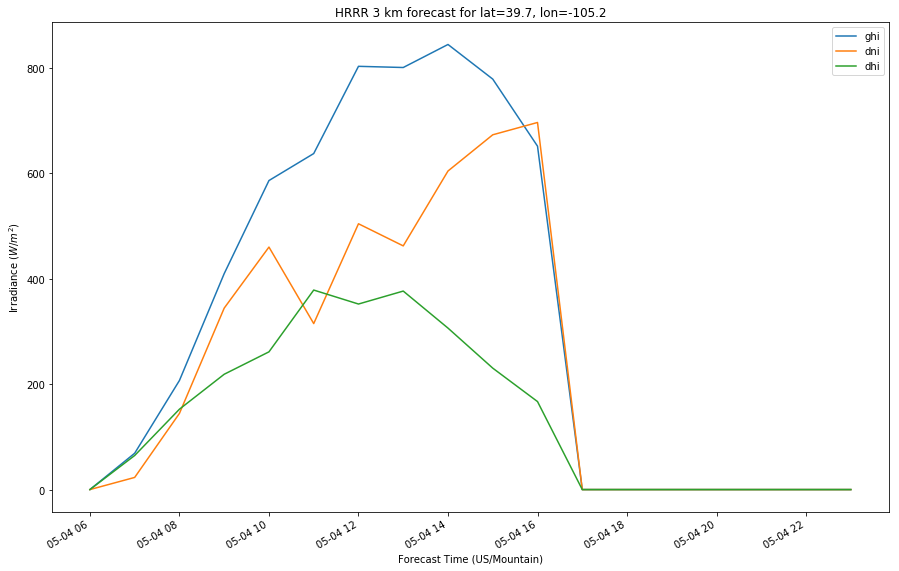

In [17]:
# High Resolution Rapid Refresh most accurate
# Only available for 15 hours
model = HRRR()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('HRRR 3 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### RAP

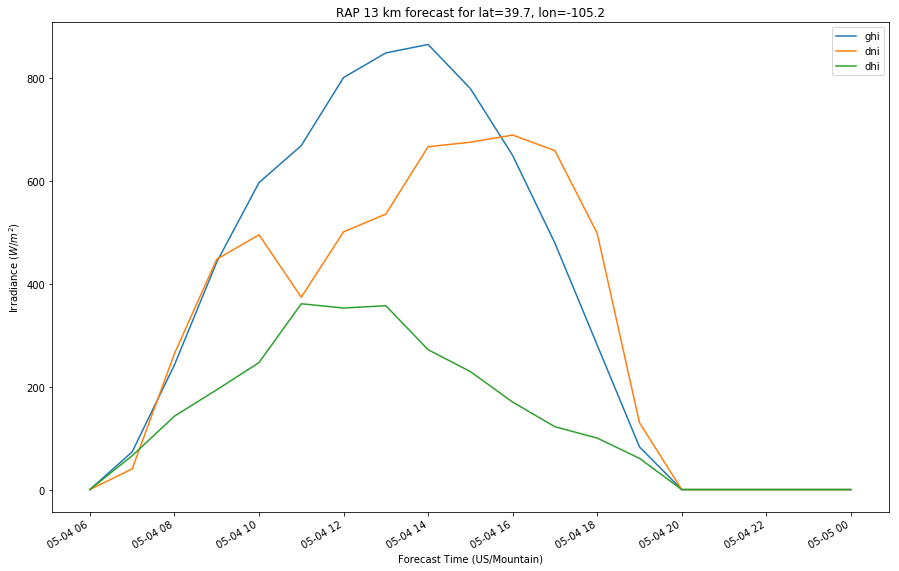

In [18]:
# The Rapid Refresh model is the parent model for the HRRR
# Updated every hour with a 20, 40 km resolution
model = RAP()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('RAP 13 km forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

### NDFD

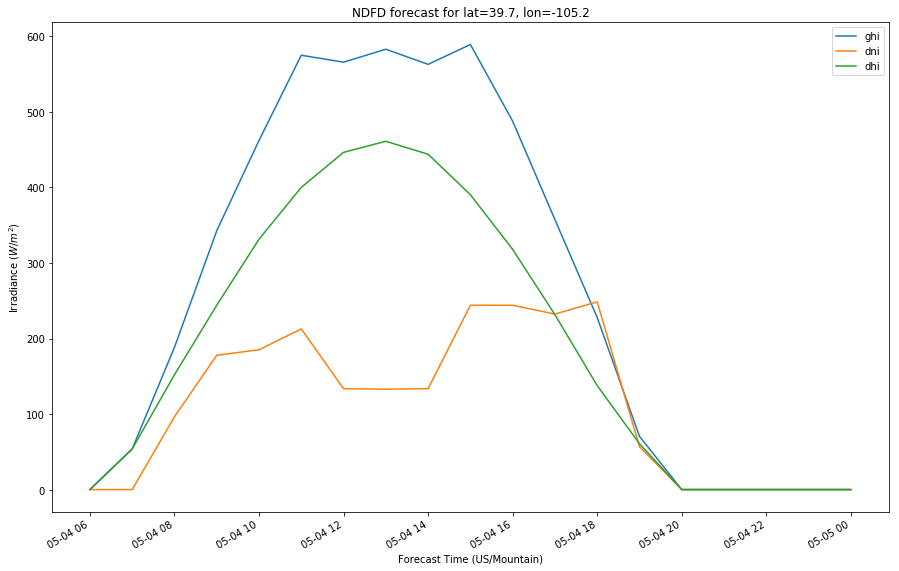

In [19]:
# The National Digital Forecast Database is not a model
# Is a collection of forecasts made by National Weather Service offices accross the country
# Updated every six hours
# Only available for the US
model = NDFD()
data = model.get_processed_data(latitude, longitude, start, end)
data[irrad_vars].plot(figsize=(15,10));
plt.ylabel('Irradiance ($W/m^2$)');
plt.xlabel('Forecast Time ({})'.format(tz));
plt.title('NDFD forecast for lat={}, lon={}'.format(latitude, longitude));
plt.legend();

## PV Power Forecast

In [20]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.tracking import SingleAxisTracker
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']
temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

# model a big tracker for more fun
system = SingleAxisTracker(module_parameters=module, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=15, strings_per_inverter=300)

# fx is a common abbreviation for forecast
fx_model = GFS()
fx_data = fx_model.get_processed_data(latitude, longitude, start, end)
ac_data = fx_data.resample('5min').interpolate()

# use a ModelChain object to calculate modeling intermediates
mc = ModelChain(system, fx_model.location)

# extract relevant data for model chain
mc.run_model(ac_data)



ModelChain: 
  name: None
  orientation_strategy: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: sapm
  ac_model: snlinverter
  aoi_model: sapm_aoi_loss
  spectral_model: sapm_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

### ModelChain Attributes

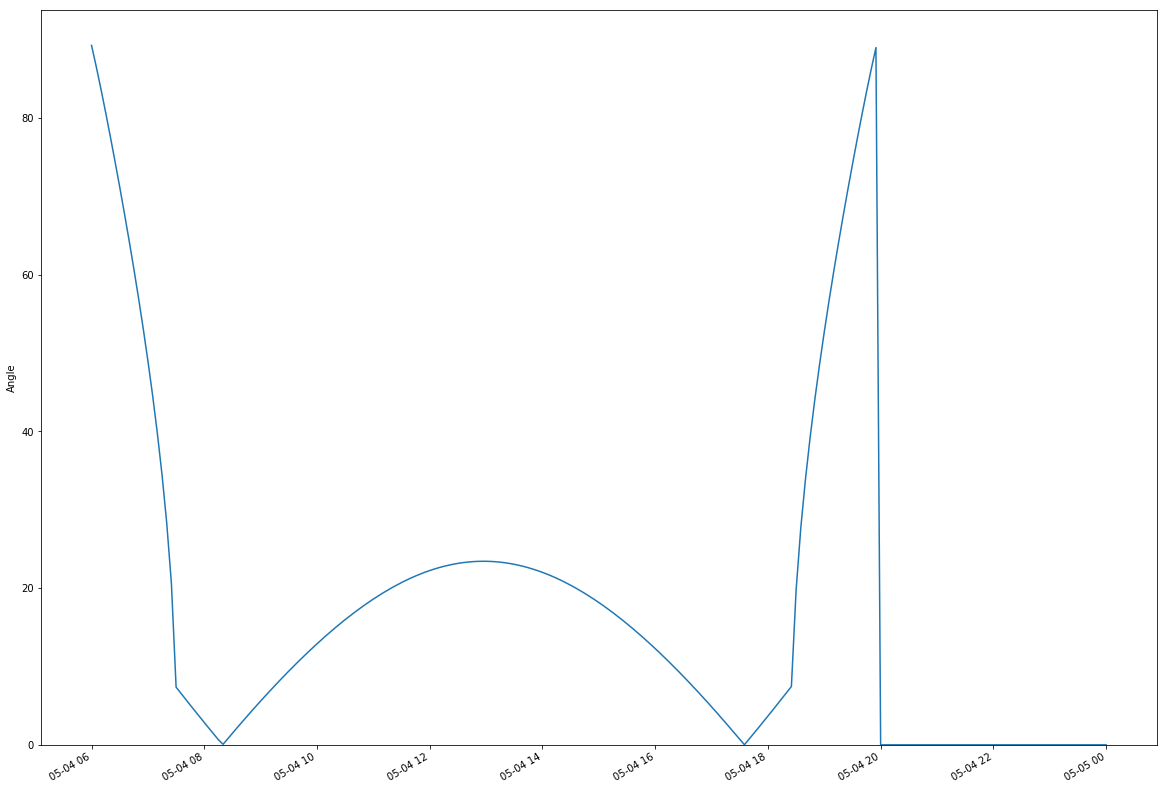

In [21]:
# ModelChain sotres modeling results on a series of attributes. 
# Angle of Incidence
mc.aoi.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('Angle');

## Modeling intermediates & Forecast power

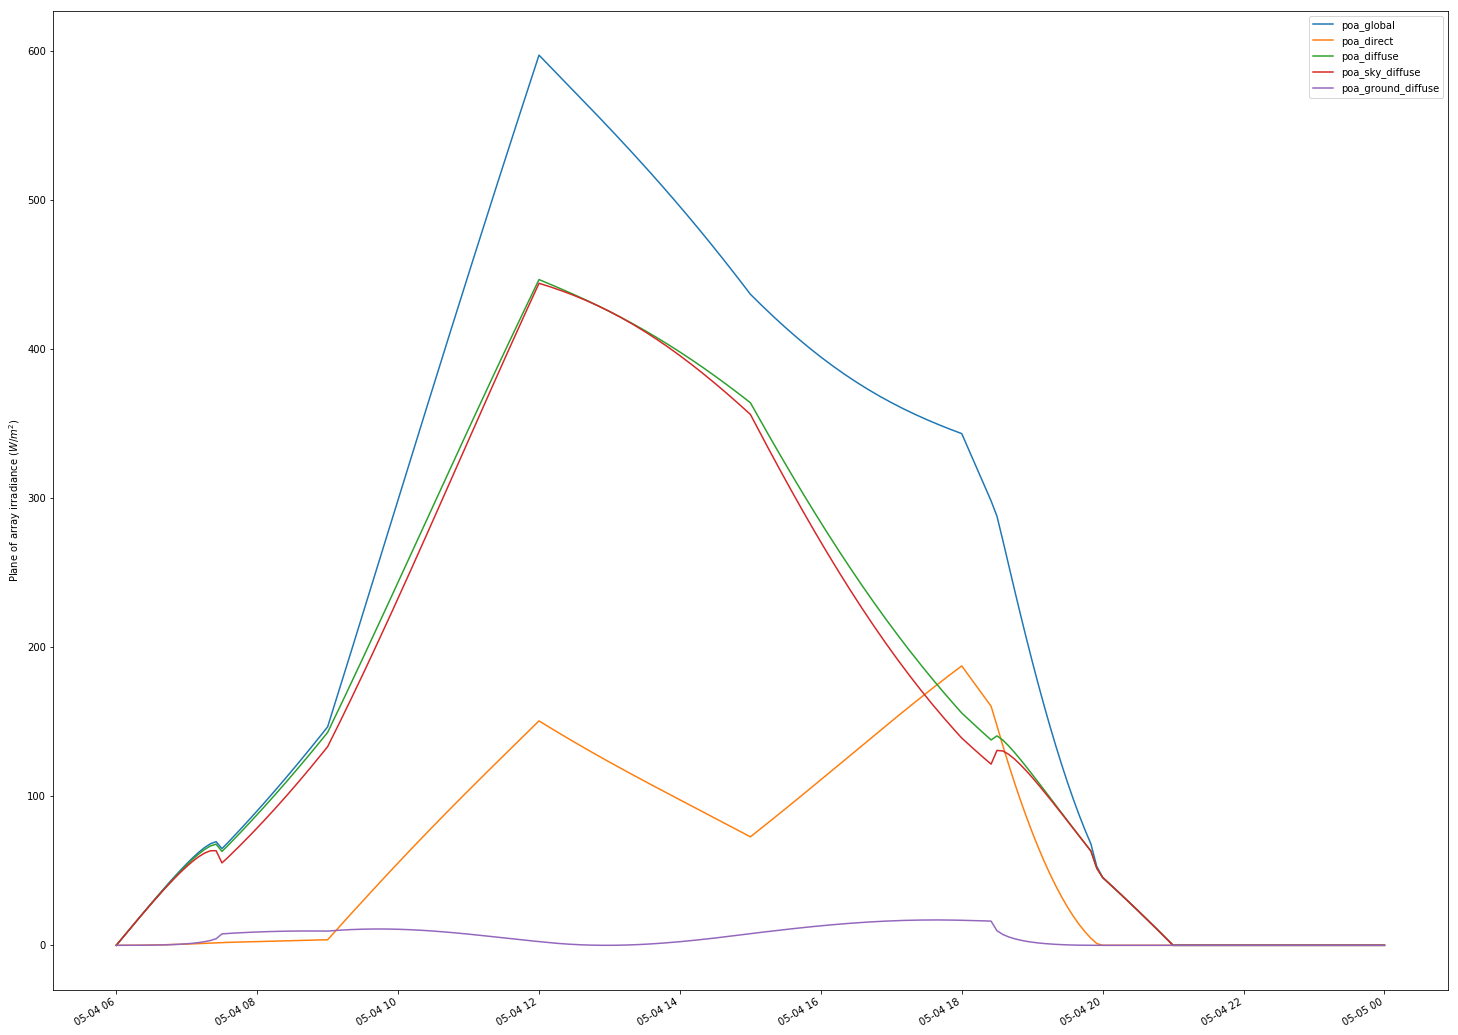

In [22]:
mc.total_irrad.plot(figsize=(25,20));
plt.ylabel('Plane of array irradiance ($W/m^2$)');
plt.legend(loc='best');

In [23]:
mc.total_irrad

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
2020-05-04 06:00:00-06:00,0.011847,0.000000,0.011847,0.011847,7.008044e-08
2020-05-04 06:05:00-06:00,4.755420,0.006266,4.749154,4.748523,6.302187e-04
2020-05-04 06:10:00-06:00,9.502648,0.022941,9.479707,9.475515,4.191379e-03
2020-05-04 06:15:00-06:00,14.245591,0.050613,14.194978,14.181429,1.354948e-02
2020-05-04 06:20:00-06:00,18.975332,0.089626,18.885706,18.853853,3.185380e-02
2020-05-04 06:25:00-06:00,23.681981,0.140181,23.541800,23.479272,6.252789e-02
2020-05-04 06:30:00-06:00,28.354546,0.202399,28.152147,28.042804,1.093427e-01
2020-05-04 06:35:00-06:00,32.980594,0.276360,32.704235,32.527689,1.765455e-01
2020-05-04 06:40:00-06:00,37.545712,0.362111,37.183601,36.914555,2.690465e-01
2020-05-04 06:45:00-06:00,42.032738,0.459681,41.573057,41.180374,3.926829e-01


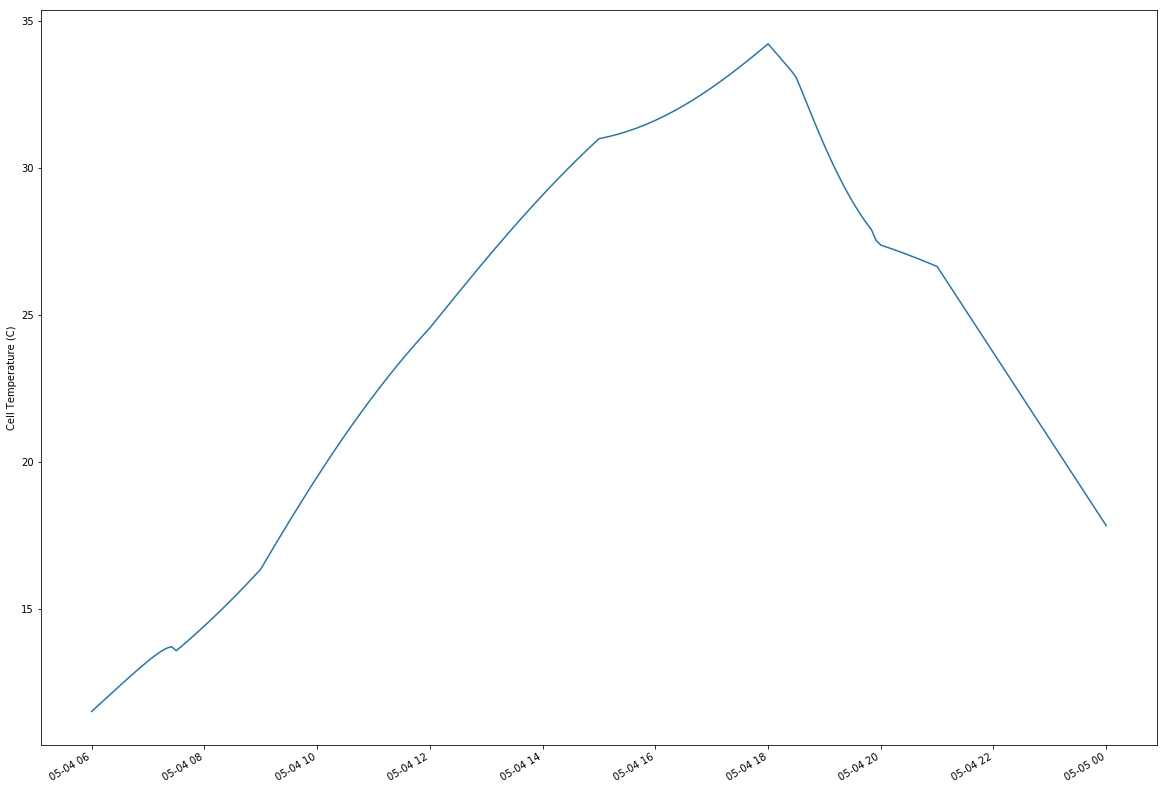

In [24]:
# Cell and module temperature
mc.cell_temperature.plot(figsize=(20,15));
plt.ylabel('Cell Temperature (C)');

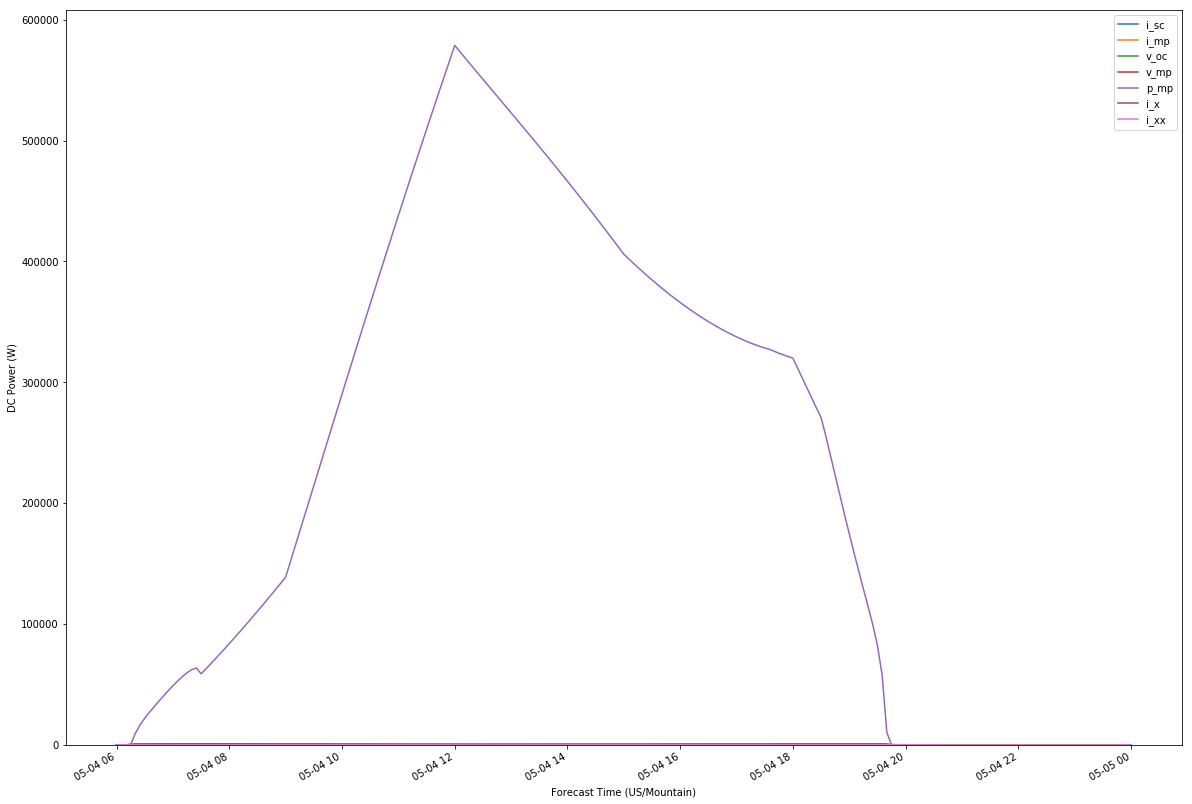

In [25]:
mc.dc.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('DC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

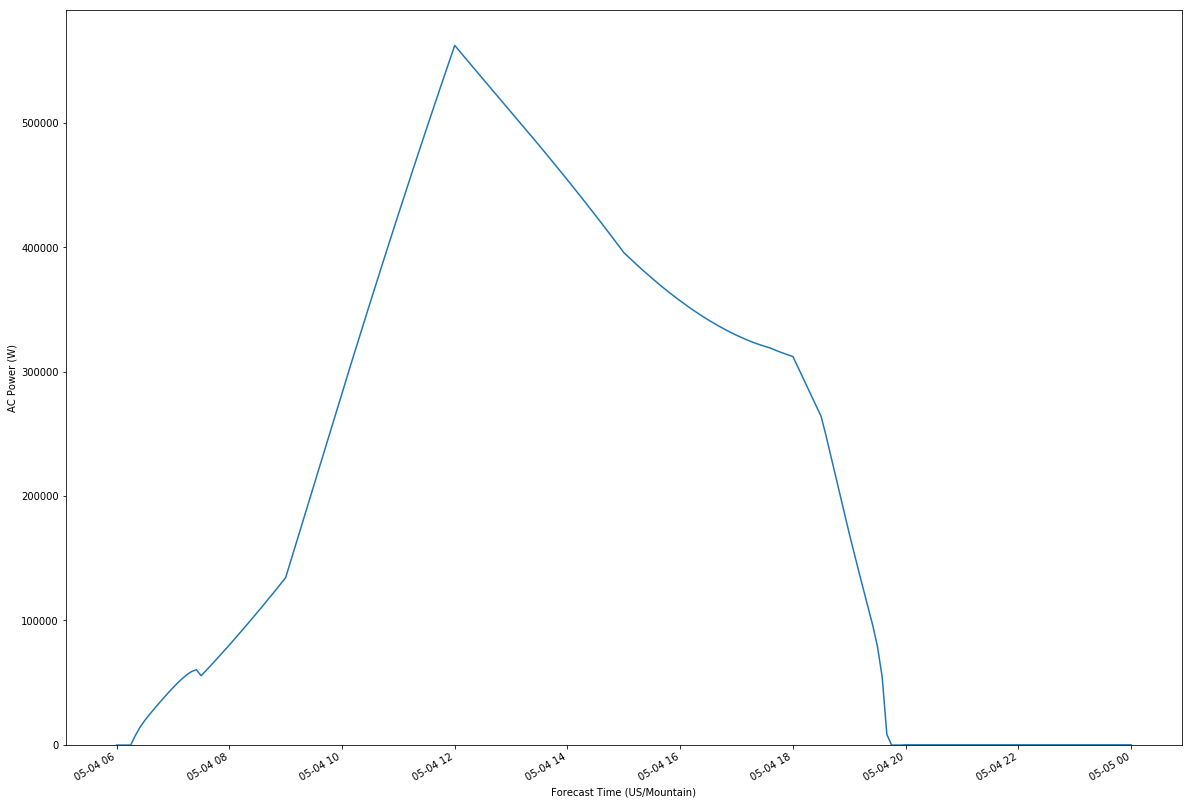

In [26]:
# AC Power
mc.ac.fillna(0).plot(figsize=(20,15));
plt.ylim(0, None);
plt.ylabel('AC Power (W)');
plt.xlabel('Forecast Time ({})'.format(tz));

In [27]:
mc.ac.fillna(0)

2020-05-04 06:00:00-06:00      -195.900000
2020-05-04 06:05:00-06:00      -195.900000
2020-05-04 06:10:00-06:00      -195.900000
2020-05-04 06:15:00-06:00      -195.900000
2020-05-04 06:20:00-06:00      7472.618040
2020-05-04 06:25:00-06:00     14182.645159
2020-05-04 06:30:00-06:00     19542.662961
2020-05-04 06:35:00-06:00     24326.546680
2020-05-04 06:40:00-06:00     28871.568937
2020-05-04 06:45:00-06:00     33295.164514
2020-05-04 06:50:00-06:00     37620.605279
2020-05-04 06:55:00-06:00     41830.746762
2020-05-04 07:00:00-06:00     45887.960177
2020-05-04 07:05:00-06:00     49738.062335
2020-05-04 07:10:00-06:00     53303.827208
2020-05-04 07:15:00-06:00     56464.572311
2020-05-04 07:20:00-06:00     58999.442019
2020-05-04 07:25:00-06:00     60372.164370
2020-05-04 07:30:00-06:00     55601.220337
2020-05-04 07:35:00-06:00     59494.994094
2020-05-04 07:40:00-06:00     63548.077987
2020-05-04 07:45:00-06:00     67649.222114
2020-05-04 07:50:00-06:00     71797.658590
2020-05-04 

In [28]:
mc.ac.describe()

count       168.000000
mean     289380.476651
std      169548.722281
min        -195.900000
25%      123839.283328
50%      323709.784568
75%      425848.597215
max      562432.286656
dtype: float64

In [29]:
mc.ac.fillna(0).to_csv('5 min AC.csv', encoding='utf-8')

# NREL Data
## Monday & Tuesday
### Irradiance & Temperature

In [30]:
# Read Irradiance & Temperature data

nrel_df = pd.read_csv('Apr 20 21.txt')
print("Keys of nrel_df: \n{}".format(nrel_df.keys()))

Keys of nrel_df: 
Index(['DATE (MM/DD/YYYY)', 'MST', 'Global Horizontal [W/m^2]',
       'Direct Normal [W/m^2]', 'Air Temperature [deg C]'],
      dtype='object')


In [31]:
# Columns Rename - Remove [ ]
nrel_df = nrel_df.rename(columns = {'Global Horizontal [W/m^2]': 'Global Horizontal', 'Direct Normal [W/m^2]': 'Direct Normal', 'Air Temperature [deg C]': 'Air Temperature', 'DATE (MM/DD/YYYY)': 'DATE'})

In [32]:
nrel_df.describe()

,Global Horizontal,Direct Normal,Air Temperature
count,1615.000000,1615.000000,1615.000000
mean,460.950268,499.459258,13.148805
std,337.869879,391.180000,3.239987
min,2.035770,0.000000,3.866000
25%,124.070500,0.000000,11.750000
50%,419.918000,675.354000,14.120000
75%,810.396500,871.377500,15.620000
max,1031.400000,950.568000,17.520000


In [33]:
nrel_df['MST'] = pd.to_datetime(nrel_df['MST'])

In [34]:
nrel_df['MST'].dt.hour + nrel_df['MST'].dt.minute/60

0        5.300000
1        5.316667
2        5.333333
3        5.350000
4        5.366667
5        5.383333
6        5.400000
7        5.416667
8        5.433333
9        5.450000
10       5.466667
11       5.483333
12       5.500000
13       5.516667
14       5.533333
15       5.550000
16       5.566667
17       5.583333
18       5.600000
19       5.616667
20       5.633333
21       5.650000
22       5.666667
23       5.683333
24       5.700000
25       5.716667
26       5.733333
27       5.750000
28       5.766667
29       5.783333
          ...    
1585    18.250000
1586    18.266667
1587    18.283333
1588    18.300000
1589    18.316667
1590    18.333333
1591    18.350000
1592    18.366667
1593    18.383333
1594    18.400000
1595    18.416667
1596    18.433333
1597    18.450000
1598    18.466667
1599    18.483333
1600    18.500000
1601    18.516667
1602    18.533333
1603    18.550000
1604    18.566667
1605    18.583333
1606    18.600000
1607    18.616667
1608    18.633333
1609    18

In [35]:
# Columns that contain NaN values (True = Nan value)
nrel_df.isnull().any()

DATE                 False
MST                  False
Global Horizontal    False
Direct Normal        False
Air Temperature      False
dtype: bool

In [36]:
nrel_df.head(10)

,DATE,MST,Global Horizontal,Direct Normal,Air Temperature
0,4/20/2020,2020-05-04 05:18:00,8.77112,0.0,3.866
1,4/20/2020,2020-05-04 05:19:00,9.35580,0.0,3.952
2,4/20/2020,2020-05-04 05:20:00,4.22616,0.0,4.043
3,4/20/2020,2020-05-04 05:21:00,5.32927,0.0,4.182
4,4/20/2020,2020-05-04 05:22:00,6.84266,0.0,4.111
5,4/20/2020,2020-05-04 05:23:00,8.57596,0.0,3.885
6,4/20/2020,2020-05-04 05:24:00,10.55430,0.0,4.092
7,4/20/2020,2020-05-04 05:25:00,12.78020,0.0,4.416
8,4/20/2020,2020-05-04 05:26:00,14.85830,0.0,4.596
9,4/20/2020,2020-05-04 05:27:00,17.32670,0.0,4.700


In [37]:
nrel_df.tail(10)

,DATE,MST,Global Horizontal,Direct Normal,Air Temperature
1605,4/21/2020,2020-05-04 18:35:00,6.62227,0.0,12.00
1606,4/21/2020,2020-05-04 18:36:00,5.79688,0.0,11.96
1607,4/21/2020,2020-05-04 18:37:00,5.00260,0.0,12.00
1608,4/21/2020,2020-05-04 18:38:00,4.23212,0.0,12.04
1609,4/21/2020,2020-05-04 18:39:00,3.46363,0.0,12.09
1610,4/21/2020,2020-05-04 18:40:00,2.85286,0.0,12.08
1611,4/21/2020,2020-05-04 18:41:00,2.20035,0.0,12.15
1612,4/21/2020,2020-05-04 18:42:00,2.03577,0.0,12.21
1613,4/21/2020,2020-05-04 18:43:00,4.91984,0.0,12.25
1614,4/21/2020,2020-05-04 18:44:00,4.47638,0.0,12.23


In [ ]:
# Plot two parameters (Power & Irradiance)
sns.lmplot('Global Horizontal','MST', data=nrel_df, hue='DATE',
           palette='Set1', fit_reg=False, scatter_kws={"s": 70}, height=12);

In [ ]:
# Visualize the relationship between Power Generated and Weather using scatterplots
sns.pairplot(nrel_df, x_vars=['Time','Irradiance', 'Temperature','CloudCover'], y_vars='Power', height=9, aspect=0.8, kind='reg')